In [1]:
import tdmclient.notebook
await tdmclient.notebook.start()

In [2]:

import cv2
import math

import numpy as np
import matplotlib.pyplot as plt
from numpy.core.fromnumeric import size
from matplotlib import colors
from asgiref.sync import sync_to_async #in order to load variables to communicate between sync and async

import optimal_path as op

from robot import Robot
from Map import Map
from Local_navigation import* 
from Mouvement import*
from vision import*
from optimal_path import* 


map_lenght = 1
nb_of_square_by_side = 50
current = 1

global move 
move = False #bool which indicate how our robot is moving (1: avoid an object VS 0: following the optimal path)
kalman_bool = False
old_distance = 0
old_angle = 0
#pourcentage_reduc = 1

In [12]:

George = Robot()
Lausanne = Map(map_lenght, nb_of_square_by_side)

#VideoCap = vision_initialization()
VideoCap=cv2.VideoCapture(0)


In [4]:
@tdmclient.notebook.sync_var
def motors(l_speed=500, r_speed=500, verbose=False):
    """
    Sets the motor speeds of the Thymio 
    param l_speed: left motor speed
    param r_speed: right motor speed
    param verbose: whether to print status messages or not
    """
    global motor_left_target, motor_right_target
    # Printing the speeds if requested
    if verbose:
        print("\t\t Setting speed : ", l_speed, r_speed)
    motor_left_target = l_speed
    motor_right_target = r_speed

In [5]:
@tdmclient.notebook.sync_var
def proxi():
    """
    Returns the proximity values of the Thymio 
    """
    global prox_horizontal
    return prox_horizontal


In [6]:
#############################
#Test MASK  A LANCER QUE POUR FAIRE DES TESTS SUR LE MASK
#############################

while True:
    ret, frame = VideoCap.read()
    mask, b = mask_map_init(frame)
    
    keyVal = cv2.waitKey(1) & 0xFF
    if keyVal == ord('q'):
        break
    cv2.imshow("mask",mask)


taille frame (480, 640, 3)
MAP INITIALISATION
goal (21, 32)
start position (39, 37)
PATH COMPUTATION


True

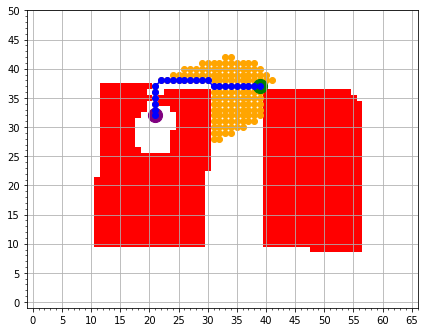

In [14]:
#np.set_printoptions(threshold=sys.maxsize)
####################################
## INIT
####################################

# Prend une première image
ret, frame = VideoCap.read()
print("taille frame", frame.shape)
cv2.imwrite("debut.jpg", frame)
print("MAP INITIALISATION")
# Set the pourcentage value between the nb of pixel and nb of square by side
Lausanne.set_map_lenght(frame)
#print("Pourcentage",Lausanne.get_pourcentage())
# Set the robot goal, position and angle
goal = init_goal(frame, Lausanne.get_pourcentage())
#goal = (50, 40)
pos_robot = George.get_pos()
#print("GOAL", goal)


#pos_robot, angle = update(frame, Lausanne.get_pourcentage())  # fonction qui retourne la position angle etc....
 
      #Utiliser au cas où il ne trouve pas la bonne position du premier coup
while (pos_robot[0] <= 0) & (pos_robot[1] <= 0):
    #ret, frame=VideoCap.read()
    #display(frame,1,0,0)
    ret, frame=VideoCap.read()
    #vs.display (frame, 0, 1, 1, 0, 5, Lausanne.get_pourcentage())
    pos_robot, angle = update(frame, Lausanne.get_pourcentage())  # fonction qui retourne la position angle etc....
    #print("Waiting robot position") 

George.set_angle(angle)
George.set_goal(goal)
George.set_start_pos(pos_robot)
George.set_pos(pos_robot)
print ("goal", goal)
print ("start position", pos_robot)

# SET MAP
Lausanne.set_map_lenght(frame)
#print("Lausanna lenght", Lausanne.get_lenght())

# MASK 
mask_bleu, mask_green = mask_map_init(frame)
#cv2.imshow("mask", mask)
cv2.imwrite("masque1.jpg", mask_bleu)
cv2.imwrite("masque2.jpg", mask_green)

# Fin de l'init
Lausanne.init_grid(mask_bleu,mask_green)
grille = Lausanne.get_map()
#cv2.imshow("grid", grille)
cv2.imwrite("grille.jpg", grille)

# OPTIMAL PATH
print("PATH COMPUTATION")
path, visitedNodes = op.path_computation(George.get_start() , George.get_goal() , Lausanne.get_lenght(), grille)

George.set_path(path) 
George.set_visit_nodes(visitedNodes) 

# Display the optimal path
op.display_map(Lausanne.get_lenght(),  grille,  George.get_visit_nodes(), George.get_path(), George.get_start(), George.get_goal())
#print("PATH", George.get_path())

display (frame, 0, 1, 1, 1, George.get_path(), Lausanne.get_pourcentage())
#print("PATH22222", George.get_path())
cv2.imwrite("TOTAL.jpg", frame)

#vision_end(VideoCap)



In [10]:

####################################
## while
####################################

George.set_current(0)
current= 0
kalman_bool = False
print("PATH", George.get_path())
old_distance = 0
old_angle = 0
soon_arrived = False
thresh_indentation = 15
print('START MOUVEMENT')
while True:#(George.get_pos() != George.get_goal()):
    
    # Read the camera
    ret, frame=VideoCap.read()
    
    # Recupere la position et angle --> XAV
    pos_robot,angle_robot = update(frame, Lausanne.get_pourcentage())
    George.set_pos(pos_robot)
    George.set_angle(angle_robot)
    
    if(current < George.get_path().shape[1]-1):
        current = path_update(pos_robot, 3, np.transpose(George.get_path())[current], George.get_current())
        George.set_current(current)
    else:
        print("ARRIVED")
        motors(0,0)
        break
    
    #print("pos", pos_robot)
    print("taille", George.get_path().shape[1])
    print("current", current)
    pos_goal =  np.transpose(George.get_path())[current]
    
    if current > (George.get_path().shape[0] - thresh_indentation) :
        soon_arrived = True
        print('soon arrived')
    
        proximity = proxi()
    
        #LOCAL NAVIGATION
    if move and not (soon_arrived):
        #Thymio is avoiding obstacles
        print("OBSTACLLLEEEE")
        speed_l, speed_r, move = avoid_obstacle(prox_horizonta=proximity) 
    else:
        #Thymio is following the optimal path
        speed_l, speed_r, old_distance, old_goal  = move_to_position(pos_robot, angle_robot, pos_goal, old_distance, old_angle)

        #Thymio is checking if there's an obstacle in front of it
        move = check_cars(prox_horizonta=proximity)
        print (speed_l, speed_r)
       
    
    
    motors(speed_l, speed_r) 
    
    display (frame, 0, 1, 1, 1, path, Lausanne.get_pourcentage())
    
    # Quit when we press q
    keyVal = cv2.waitKey(1) & 0xFF
    if keyVal == ord('q'):
        motors(0,0)
        break
     
    sleep(0.1)


print("The End")
    

PATH [[39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 21 21 21 21 21]
 [37 37 37 37 37 37 37 37 37 38 38 38 38 38 38 38 38 38 37 36 35 34 33 32]]
START MOUVEMENT
PATH [39 37]
X 0
Y 0
next goal plz
taille 24
current 1
soon arrived
movement
(39, 37)
old dist, 0 old angle 0
debut 39 37 -0.7221913314999882
dist_debut 1.0
angle_goal, 3.141592653589793
3.863783985089781
alpha -2.419401322089805
v 2.0
w -1258.0886874866985
new dist, 1.0 new angle -2.419401322089805
v2 2.0
speed_original, 1258 -1258
speed, 0 0
0 0
PATH [38 37]
X 1
Y 0
next goal plz
taille 24
current 2
soon arrived
movement
(39, 37)
old dist, 1.0 old angle 0
debut 39 37 -0.7221913314999882
dist_debut 2.0
angle_goal, 3.141592653589793
3.863783985089781
alpha -2.419401322089805
v 4.0
w -1258.0886874866985
new dist, 2.0 new angle -2.419401322089805
v2 4.0
speed_original, 1258 -1258
speed, 200 -1258
200 -1258
PATH [37 37]
X 2
Y 0
next goal plz
taille 24
current 3
soon arrived
movement
(39, 37)
old dist, 2.0 old angle 0
de

200 -1258
PATH [36 37]
X 3
Y 0
taille 24
current 3
soon arrived
movement
(39, 37)
old dist, 3.0 old angle 0
debut 39 37 -0.7221913314999882
dist_debut 3.0
angle_goal, 3.141592653589793
3.863783985089781
alpha -2.419401322089805
v 6.0
w -1258.0886874866985
new dist, 3.0 new angle -2.419401322089805
v2 6.0
speed_original, 1258 -1258
speed, 200 -1258
200 -1258
PATH [36 37]
X 3
Y 0
taille 24
current 3
soon arrived
movement
(39, 37)
old dist, 3.0 old angle 0
debut 39 37 -0.7221913314999882
dist_debut 3.0
angle_goal, 3.141592653589793
3.863783985089781
alpha -2.419401322089805
v 6.0
w -1258.0886874866985
new dist, 3.0 new angle -2.419401322089805
v2 6.0
speed_original, 1258 -1258
speed, 200 -1258
200 -1258
PATH [36 37]
X 3
Y 0
taille 24
current 3
soon arrived
movement
(39, 37)
old dist, 3.0 old angle 0
debut 39 37 -0.7221913314999882
dist_debut 3.0
angle_goal, 3.141592653589793
3.863783985089781
alpha -2.419401322089805
v 6.0
w -1258.0886874866985
new dist, 3.0 new angle -2.419401322089805
v

In [9]:
vision_end(VideoCap)

In [9]:
motors(0,0)